In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple
from dateutil.parser import parse as dateparse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA   # <-- ARIMA here
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\ALKA\OneDrive\Desktop\Data Analytics project\Softnix internship\Extractdir\airline-passengers.csv", parse_dates=['Month'], index_col='Month')

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.rename(columns={'Passengers':'Passengers'}, inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# 2. Resample to Quarterly (taking mean passenger count per quarter)
quarterly = df.resample('Q').mean()

In [6]:
quarterly.head()

,Passengers
Month,
1949-03-31,120.666667
1949-06-30,128.333333
1949-09-30,144.000000
1949-12-31,113.666667
1950-03-31,127.333333


In [7]:
# Quick inspection
print("Data range:", df.index.min(), "to", df.index.max())
print("Total observations:", len(df))
display(df.head())

Data range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Total observations: 144


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
decomposition = seasonal_decompose(df, model='multiplicative')

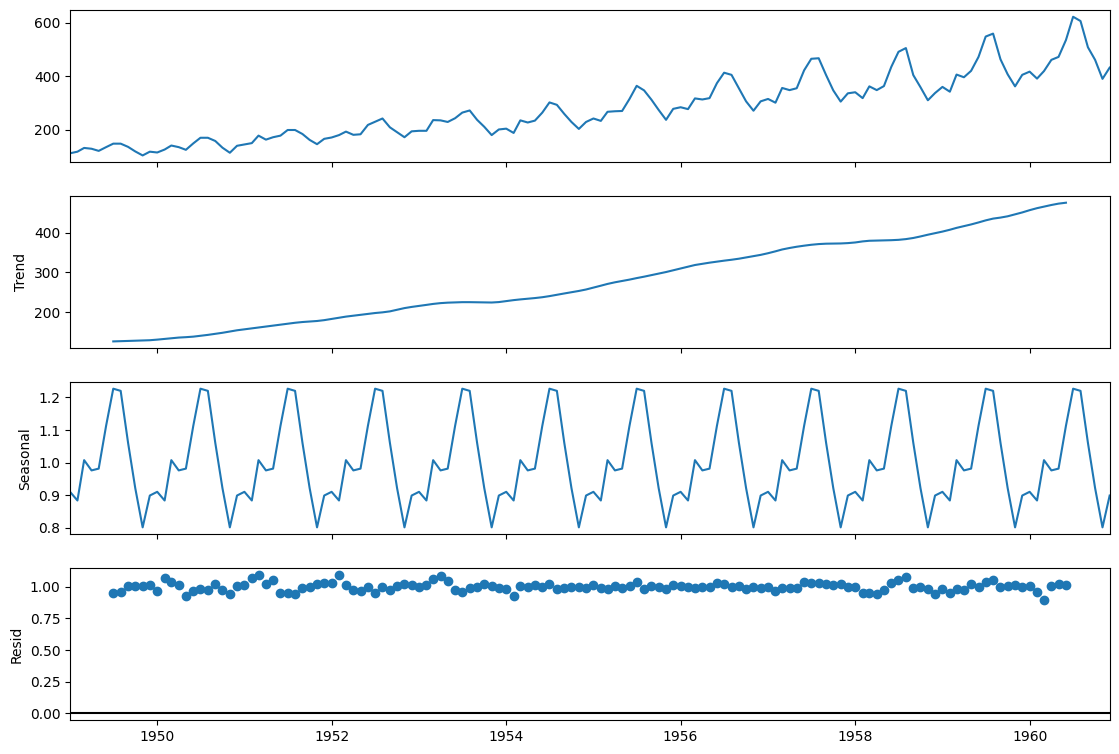

In [9]:
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show()

In [10]:
#6-month and 12-month moving averages
df['MA_6'] = df['Passengers'].rolling(window=6).mean()
df['MA_12'] = df['Passengers'].rolling(window=12).mean()

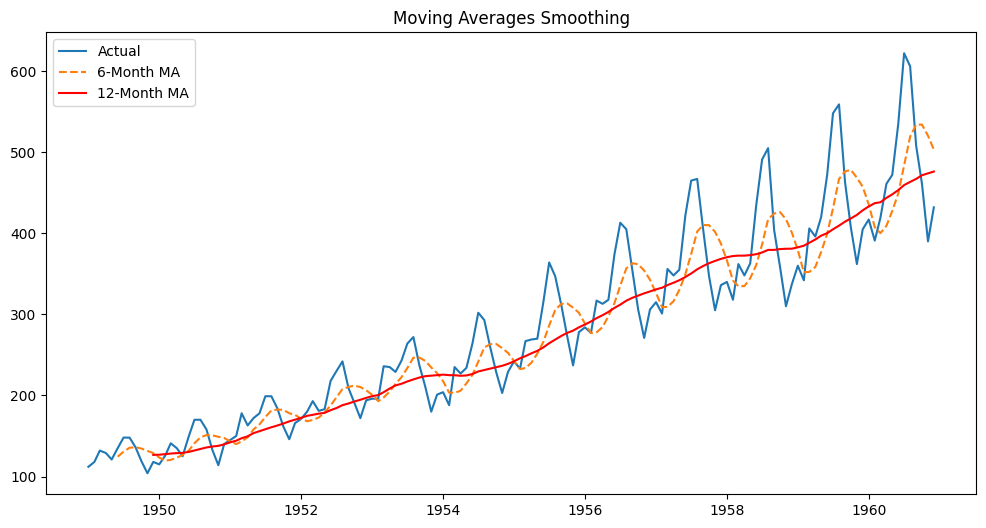

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Actual')
plt.plot(df['MA_6'], label='6-Month MA', linestyle='--')
plt.plot(df['MA_12'], label='12-Month MA', color='red')
plt.legend()
plt.title('Moving Averages Smoothing')
plt.show()

In [12]:
#split data (last 12 months for testing)
train = df.iloc[:-12]
test = df.iloc[-12:]

In [13]:
# Select only the target column
y_train = train['Passengers']
y_test  = test['Passengers']

In [14]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
model = SARIMAX(y_train, order=(2,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -445.700
Date:                            Wed, 10 Sep 2025   AIC                            903.400
Time:                                    15:49:34   BIC                            920.075
Sample:                                01-01-1949   HQIC                           910.171
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5077      1.369     -0.371      0.711      -3.190       2.175
ar.L2         -0.0039      0.401   

In [16]:
# Forecast for 12 months ahead
forecast = result.forecast(steps=12)

In [17]:
# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f"RMSE: {rmse:.1f} passengers")

RMSE: 21.2 passengers


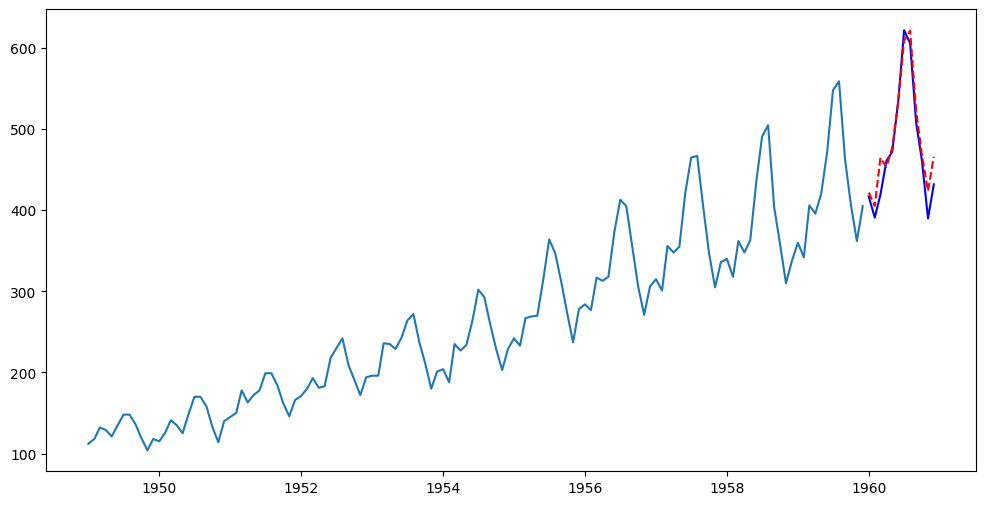

In [18]:
# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, forecast, label='Forecast', color='red', linestyle='--')


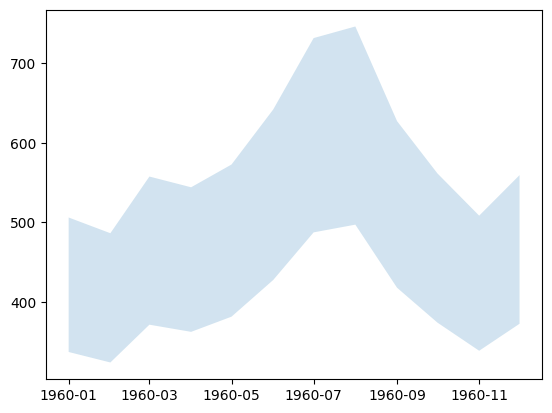

In [19]:
# Confidence-style band (±20% for quick visual, not true conf. interval)
plt.fill_between(y_test.index, forecast*0.8, forecast*1.2, alpha=0.2)

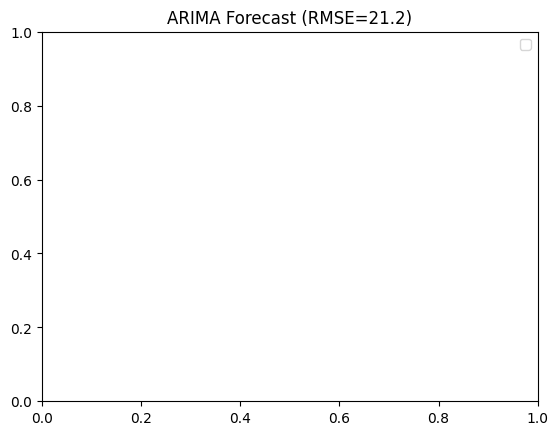

In [20]:
plt.title(f"ARIMA Forecast (RMSE={rmse:.1f})")
plt.legend()
plt.show()

In [21]:
df1 = pd.read_csv(r"C:\Users\ALKA\OneDrive\Desktop\Data Analytics project\Softnix internship\Extractdir\AAPL(80-24) Final.csv")

In [22]:
# Convert Date to datetime and set as index
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.sort_values('Date')   # ensure chronological order
df1.set_index('Date', inplace=True)

In [23]:
df1.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1980-12-12,0.13,0.13,0.13,0.13,469.03M,-99.88%
1980-12-15,0.12,0.12,0.12,0.12,175.88M,-7.69%
1980-12-16,0.11,0.11,0.11,0.11,105.73M,-8.33%
1980-12-17,0.12,0.12,0.12,0.12,86.44M,9.09%
1980-12-18,0.12,0.12,0.12,0.12,73.45M,0.00%


In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10912 entries, 1980-12-12 to 2024-03-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     10912 non-null  float64
 1   Open      10912 non-null  float64
 2   High      10912 non-null  float64
 3   Low       10912 non-null  float64
 4   Vol.      10911 non-null  object 
 5   Change %  10912 non-null  object 
dtypes: float64(4), object(2)
memory usage: 596.8+ KB


In [25]:
# Use the closing Price for decomposition
series = df1['Price']

# Decompose with yearly seasonality (252 trading days)
decomposition = seasonal_decompose(series, model='multiplicative', period=252)

<Figure size 1200x800 with 0 Axes>

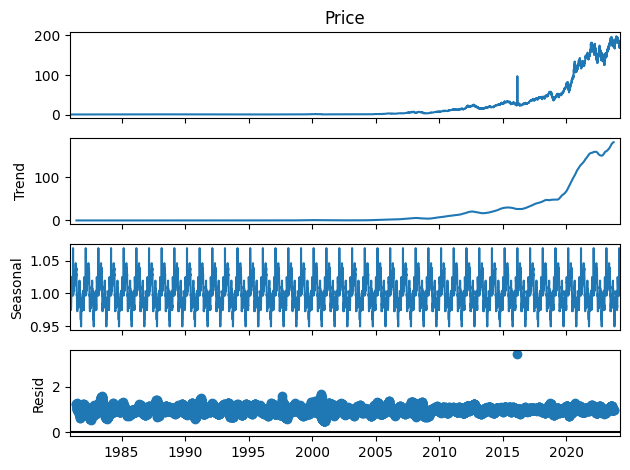

In [26]:
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

In [27]:

# 6-month (~126 trading days) and 12-month (~252 trading days) moving averages
df1['MA_6'] = df1['Price'].rolling(window=126).mean()
df1['MA_12'] = df1['Price'].rolling(window=252).mean()

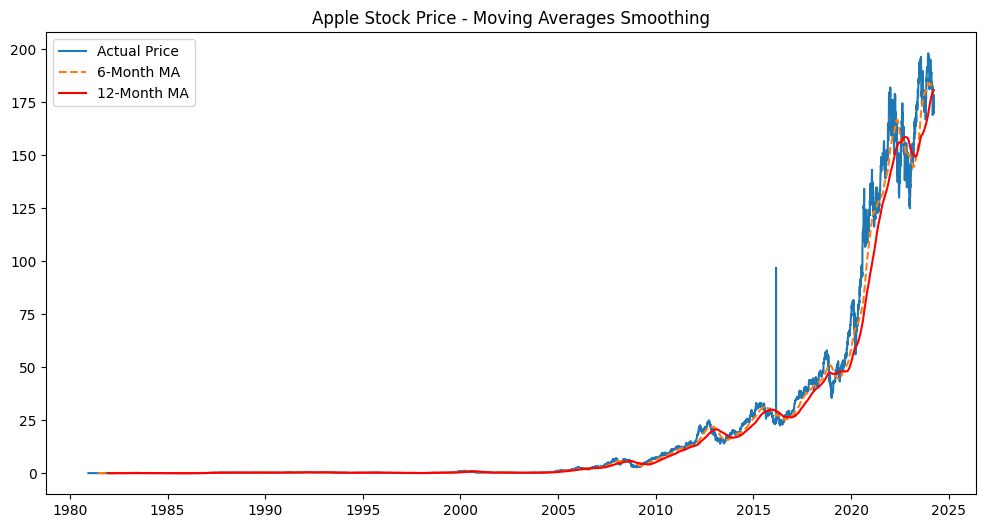

In [28]:
# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(df1['Price'], label='Actual Price')
plt.plot(df1['MA_6'], label='6-Month MA', linestyle='--')
plt.plot(df1['MA_12'], label='12-Month MA', color='red')
plt.legend()
plt.title('Apple Stock Price - Moving Averages Smoothing')
plt.show()

In [29]:
# Use Price series
series = df1['Price']

In [30]:
# Train-test split (last 252 trading days = ~1 year for testing)
train = series.iloc[:-252]
test = series.iloc[-252:]


In [31]:
# Fit ARIMA model
model = ARIMA(train, order=(2,1,1))
result = model.fit()

In [32]:
# Forecast
forecast = result.forecast(steps=252)

# Evaluate
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.2f}")

RMSE: 23.92


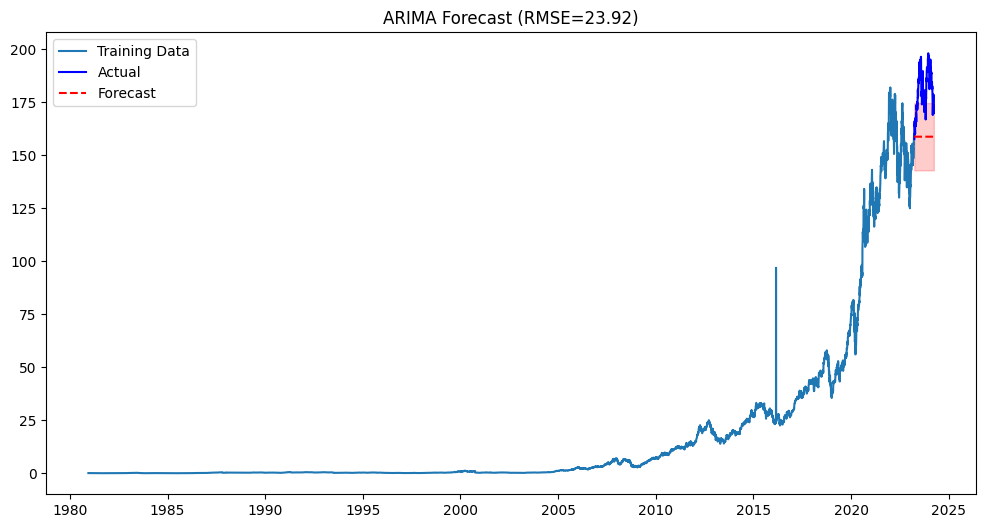

In [33]:
# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.fill_between(test.index, forecast*0.9, forecast*1.1, alpha=0.2, color='red')
plt.title(f"ARIMA Forecast (RMSE={rmse:.2f})")
plt.legend()
plt.show()

In [35]:
df2 = pd.read_csv(r"C:\Users\ALKA\OneDrive\Desktop\Data Analytics project\Softnix internship\Extractdir\SuperMarket Analysis.csv")

In [36]:
df2.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [38]:
df2.shape

(1000, 17)

In [39]:
df2.head().to_dict()

{'Invoice ID': {0: '750-67-8428',
  1: '226-31-3081',
  2: '631-41-3108',
  3: '123-19-1176',
  4: '373-73-7910'},
 'Branch': {0: 'Alex', 1: 'Giza', 2: 'Alex', 3: 'Alex', 4: 'Alex'},
 'City': {0: 'Yangon', 1: 'Naypyitaw', 2: 'Yangon', 3: 'Yangon', 4: 'Yangon'},
 'Customer type': {0: 'Member',
  1: 'Normal',
  2: 'Normal',
  3: 'Member',
  4: 'Member'},
 'Gender': {0: 'Female', 1: 'Female', 2: 'Female', 3: 'Female', 4: 'Female'},
 'Product line': {0: 'Health and beauty',
  1: 'Electronic accessories',
  2: 'Home and lifestyle',
  3: 'Health and beauty',
  4: 'Sports and travel'},
 'Unit price': {0: 74.69, 1: 15.28, 2: 46.33, 3: 58.22, 4: 86.31},
 'Quantity': {0: 7, 1: 5, 2: 7, 3: 8, 4: 7},
 'Tax 5%': {0: 26.1415, 1: 3.82, 2: 16.2155, 3: 23.288, 4: 30.2085},
 'Sales': {0: 548.9715, 1: 80.22, 2: 340.5255, 3: 489.048, 4: 634.3785},
 'Date': {0: '1/5/2019',
  1: '3/8/2019',
  2: '3/3/2019',
  3: '1/27/2019',
  4: '2/8/2019'},
 'Time': {0: '1:08:00 PM',
  1: '10:29:00 AM',
  2: '1:23:00 PM',

In [47]:
# convert date column to datetime

df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

In [48]:
# Aggregate Sales by Date (daily total sales)
daily_sales = df2.groupby('Date')['Sales'].sum().reset_index()
print("Daily Sales Data:\n", daily_sales.head())

Daily Sales Data:
         Date      Sales
0 2019-01-01  4745.1810
1 2019-01-02  1945.5030
2 2019-01-03  2078.1285
3 2019-01-04  1623.6885
4 2019-01-05  3536.6835


In [49]:
# Set Date as index for time series

daily_sales.set_index('Date', inplace=True)
print("Time Series Head:\n", daily_sales.head())

Time Series Head:
                 Sales
Date                 
2019-01-01  4745.1810
2019-01-02  1945.5030
2019-01-03  2078.1285
2019-01-04  1623.6885
2019-01-05  3536.6835


In [ ]:
# Resample Daily -> Monthly
monthly = daily_sales.resample('M').sum()           # or .mean() depending on analysis
print("Monthly Sales:\n", monthly.head())

# Monthly → Quarterly
quarterly = monthly.resample('Q').sum()   # quarterly total sales
print("Quarterly Sales:\n", quarterly.head())

Monthly Sales:
                  Sales
Date                  
2019-01-31  116291.868
2019-02-28   97219.374
2019-03-31  109455.507
Quarterly Sales:
                  Sales
Date                  
2019-03-31  322966.749


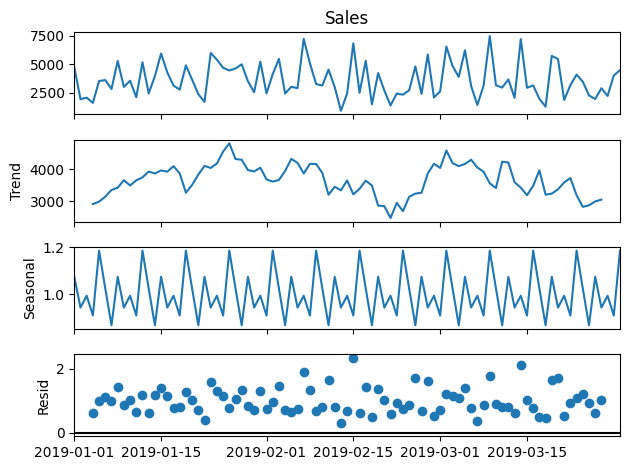

In [56]:
decomposition = seasonal_decompose(daily_sales['Sales'], model='multiplicative', period=7)  # weekly seasonality
decomposition.plot()
plt.show()


In [57]:
# Daily Sales Moving Average
# 7-day and 30-day moving averages on daily sales
daily_sales['MA_7'] = daily_sales['Sales'].rolling(window=7).mean()
daily_sales['MA_30'] = daily_sales['Sales'].rolling(window=30).mean()

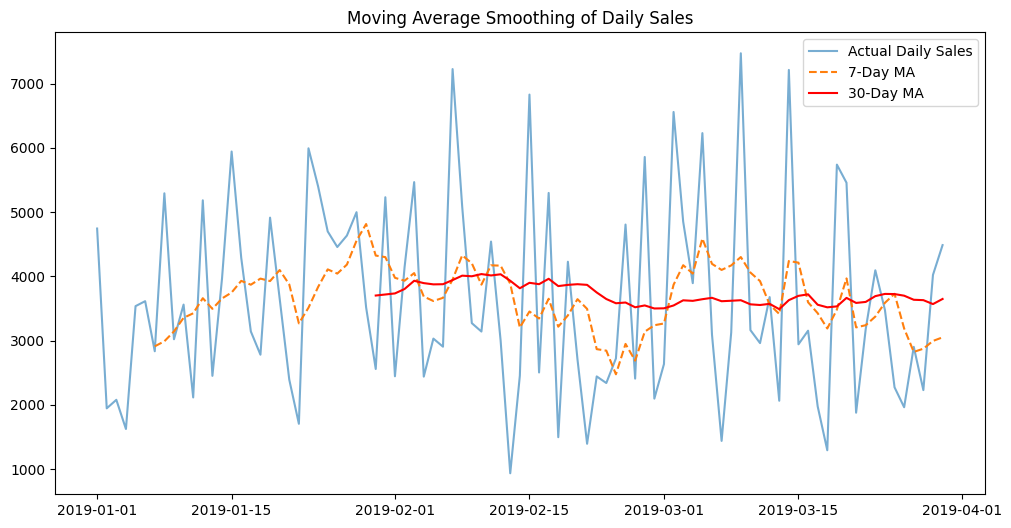

In [58]:
# Plot comparison
plt.figure(figsize=(12,6))
plt.plot(daily_sales['Sales'], label='Actual Daily Sales', alpha=0.6)
plt.plot(daily_sales['MA_7'], label='7-Day MA', linestyle='--')
plt.plot(daily_sales['MA_30'], label='30-Day MA', color='red')
plt.legend()
plt.title('Moving Average Smoothing of Daily Sales')
plt.show()

In [64]:
# Use daily sales for ARIMA
ts = daily_sales['Sales']

In [65]:
# Train-test split (last 14 days for testing)
train = ts.iloc[:-14]
test = ts.iloc[-14:]



In [66]:
# Fit ARIMA model
model = ARIMA(train, order=(2,1,1))
result = model.fit()

In [67]:
# Forecast
forecast = result.forecast(steps=14)

In [68]:
# Evaluate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.2f} sales")

RMSE: 1431.57 sales


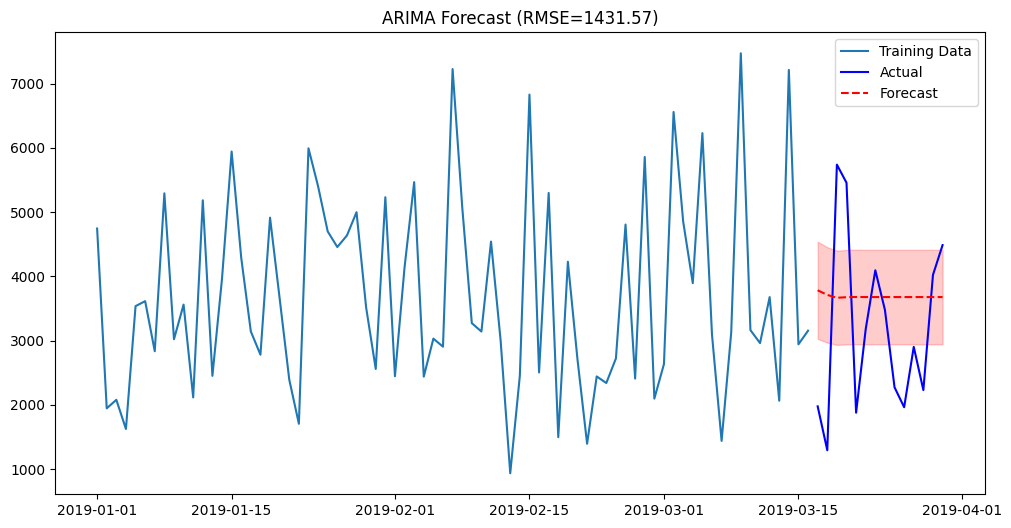

In [69]:
# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.fill_between(test.index, forecast*0.8, forecast*1.2, alpha=0.2, color='red')
plt.title(f"ARIMA Forecast (RMSE={rmse:.2f})")
plt.legend()
plt.show()